In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")
len(candles)

loading NQ_1


99990

In [2]:
model = tf.keras.models.load_model("model.keras")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                              

In [3]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [4]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L

        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

                last_action = 0
                if output[0] > t:
                    last_action = 1
                if output[0] < -t:
                    last_action = -1

                outputs.append(output[0])
            else:
                last_action = 0


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 0 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == -1 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == -1 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  avg_candle_range * tpm


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  avg_candle_range * tpm

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [5]:
m = MultiTimeframeCandleManager()

t = 0.1
slm = 3
tpm = 6

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(100000)):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0


  2%|█▊                                                                       | 2459/100000 [00:00<00:04, 24378.97it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 -2.25

 60.95000000000073

 34.13750000000073


  5%|███▌                                                                      | 4897/100000 [00:02<00:51, 1857.30it/s]


 -1.8125

 36.787499999998545

 -18.850000000002183

 -43.76250000000073

 -55.087500000001455

 -124.80000000000291

 -132.25

 -307.5125000000007

 -163.01250000000073

 -214.57500000000073

 -146.59999999999854


  6%|████▍                                                                      | 5967/100000 [00:06<02:20, 671.05it/s]


 -192.28749999999854

 -249.48749999999927

 -263.4874999999993

 -249.22499999999854

 -237.52499999999782

 -262.9249999999993


  7%|████▉                                                                      | 6560/100000 [00:09<03:06, 501.64it/s]


 -297.8875000000007

 -325.5750000000007

 -345.68750000000364


  7%|█████▏                                                                     | 6928/100000 [00:10<03:37, 427.31it/s]


 -472.62500000000364

 -629.1875

 -662.8500000000022


  7%|█████▍                                                                     | 7171/100000 [00:11<03:55, 393.35it/s]


 -663.5625000000036


  7%|█████▌                                                                     | 7340/100000 [00:12<04:10, 370.54it/s]


 -618.7750000000015

 -553.0250000000015


  7%|█████▌                                                                     | 7462/100000 [00:13<04:22, 352.32it/s]


 -495.75


  8%|█████▋                                                                     | 7624/100000 [00:13<04:44, 324.53it/s]


 -513.3499999999985


  8%|█████▊                                                                     | 7725/100000 [00:14<05:12, 295.06it/s]


 -563.5250000000015


  8%|█████▊                                                                     | 7824/100000 [00:14<06:04, 252.61it/s]


 -606.2000000000007


  8%|█████▉                                                                     | 7937/100000 [00:15<07:16, 210.84it/s]


 -648.4000000000015


  8%|██████                                                                     | 8021/100000 [00:15<07:32, 203.14it/s]


 -607.375


  8%|██████                                                                     | 8137/100000 [00:16<06:39, 229.66it/s]


 -548.8250000000007


  8%|██████▏                                                                    | 8234/100000 [00:16<06:30, 234.88it/s]


 -484.1750000000029


  8%|██████▏                                                                    | 8333/100000 [00:17<06:31, 233.93it/s]


 -611.9875000000029


  8%|██████▎                                                                    | 8431/100000 [00:17<06:26, 236.70it/s]


 -605.8750000000036


  9%|██████▍                                                                    | 8529/100000 [00:17<06:16, 242.88it/s]


 -530.4000000000051


  9%|██████▍                                                                    | 8630/100000 [00:18<06:12, 245.44it/s]


 -536.4625000000087


  9%|██████▌                                                                    | 8732/100000 [00:18<06:13, 244.09it/s]


 -599.6250000000073


  9%|██████▌                                                                    | 8832/100000 [00:19<06:12, 244.85it/s]


 -585.1250000000073


  9%|██████▋                                                                    | 8932/100000 [00:19<06:13, 244.07it/s]


 -563.0375000000095


  9%|██████▊                                                                    | 9032/100000 [00:20<06:10, 245.75it/s]


 -571.9000000000087


  9%|██████▊                                                                    | 9132/100000 [00:20<06:11, 244.50it/s]


 -581.7750000000087


  9%|██████▉                                                                    | 9233/100000 [00:20<06:08, 246.22it/s]


 -548.0500000000065


  9%|██████▉                                                                    | 9333/100000 [00:21<06:06, 247.57it/s]


 -526.9125000000058


  9%|███████                                                                    | 9434/100000 [00:21<06:17, 239.89it/s]


 -528.9125000000058


 10%|███████▏                                                                   | 9536/100000 [00:22<06:05, 247.20it/s]


 -515.9125000000058


 10%|███████▏                                                                   | 9637/100000 [00:22<06:04, 247.86it/s]


 -472.2875000000058


 10%|███████▎                                                                   | 9737/100000 [00:22<06:22, 235.78it/s]


 -425.80000000000655


 10%|███████▍                                                                   | 9834/100000 [00:23<06:28, 231.80it/s]


 -409.2125000000051


 10%|███████▍                                                                   | 9932/100000 [00:23<06:20, 236.52it/s]


 -422.00000000000364


 10%|███████▍                                                                  | 10031/100000 [00:24<06:12, 241.21it/s]


 -442.5500000000029


 10%|███████▍                                                                  | 10129/100000 [00:24<06:21, 235.70it/s]


 -469.3125


 10%|███████▌                                                                  | 10228/100000 [00:25<06:31, 229.12it/s]


 -460.4874999999993


 10%|███████▋                                                                  | 10325/100000 [00:25<06:33, 227.84it/s]


 -448.7999999999993


 10%|███████▋                                                                  | 10423/100000 [00:25<06:23, 233.40it/s]


 -404.1000000000022


 11%|███████▊                                                                  | 10521/100000 [00:26<06:27, 230.99it/s]


 -328.52500000000146


 11%|███████▉                                                                  | 10643/100000 [00:26<06:24, 232.32it/s]


 -351.8000000000029


 11%|███████▉                                                                  | 10739/100000 [00:27<06:22, 233.11it/s]


 -352.9875000000029


 11%|████████                                                                  | 10836/100000 [00:27<06:25, 231.21it/s]


 -389.1750000000029


 11%|████████                                                                  | 10932/100000 [00:28<06:24, 231.36it/s]


 -382.1750000000029


 11%|████████▏                                                                 | 11031/100000 [00:28<06:17, 235.94it/s]


 -390.6625000000022


 11%|████████▏                                                                 | 11129/100000 [00:28<06:11, 239.20it/s]


 -346.4125000000022


 11%|████████▎                                                                 | 11229/100000 [00:29<06:10, 239.83it/s]


 -413.93750000000364


 11%|████████▍                                                                 | 11327/100000 [00:29<06:17, 234.93it/s]


 -430.2375000000029


 11%|████████▍                                                                 | 11451/100000 [00:30<06:07, 240.85it/s]


 -433.13750000000437


 12%|████████▌                                                                 | 11526/100000 [00:30<06:07, 240.89it/s]


 -462.06250000000364


 12%|████████▌                                                                 | 11624/100000 [00:31<06:15, 235.08it/s]


 -477.77500000000146


 12%|████████▋                                                                 | 11747/100000 [00:31<06:18, 233.47it/s]


 -480.65000000000146


 12%|████████▋                                                                 | 11822/100000 [00:31<06:06, 240.75it/s]


 -497.58750000000146


 12%|████████▊                                                                 | 11938/100000 [00:32<06:51, 213.82it/s]


 -485.08750000000146


 12%|████████▉                                                                 | 12031/100000 [00:32<06:37, 221.30it/s]


 -472.1125000000029


 12%|████████▉                                                                 | 12118/100000 [00:33<07:13, 202.91it/s]


 -536.6624999999985


 12%|█████████                                                                 | 12226/100000 [00:33<07:08, 204.90it/s]


 -394.41249999999854


 12%|█████████                                                                 | 12322/100000 [00:34<06:22, 229.47it/s]


 -480.72499999999854


 12%|█████████▏                                                                | 12444/100000 [00:34<06:32, 222.92it/s]


 -484.93749999999636


 13%|█████████▎                                                                | 12530/100000 [00:35<07:44, 188.28it/s]


 -523.4874999999956


 13%|█████████▎                                                                | 12634/100000 [00:35<07:26, 195.56it/s]


 -536.0874999999942


 13%|█████████▍                                                                | 12737/100000 [00:36<07:23, 196.93it/s]


 -529.4124999999949


 13%|█████████▍                                                                | 12822/100000 [00:36<07:20, 197.95it/s]


 -552.1624999999949


 13%|█████████▌                                                                | 12927/100000 [00:37<07:16, 199.69it/s]


 -560.0499999999956


 13%|█████████▋                                                                | 13033/100000 [00:37<07:08, 202.75it/s]


 -563.3624999999956


 13%|█████████▋                                                                | 13140/100000 [00:38<06:59, 206.94it/s]


 -534.3874999999935


 13%|█████████▊                                                                | 13224/100000 [00:38<07:41, 187.94it/s]


 -552.799999999992


 13%|█████████▊                                                                | 13330/100000 [00:39<07:04, 204.28it/s]


 -556.299999999992


 13%|█████████▉                                                                | 13413/100000 [00:39<07:36, 189.71it/s]


 -592.0624999999927


 14%|██████████                                                                | 13534/100000 [00:40<07:35, 189.68it/s]


 -743.2874999999913


 14%|██████████                                                                | 13641/100000 [00:40<07:01, 204.86it/s]


 -757.0124999999898


 14%|██████████▏                                                               | 13724/100000 [00:41<07:11, 199.75it/s]


 -868.5249999999905


 14%|██████████▏                                                               | 13830/100000 [00:41<07:03, 203.71it/s]


 -929.4499999999898


 14%|██████████▎                                                               | 13936/100000 [00:42<07:02, 203.57it/s]


 -833.9499999999898


 14%|██████████▍                                                               | 14021/100000 [00:42<07:03, 202.94it/s]


 -857.6999999999898


 14%|██████████▍                                                               | 14129/100000 [00:43<06:55, 206.87it/s]


 -897.7624999999898


 14%|██████████▌                                                               | 14234/100000 [00:43<06:59, 204.61it/s]


 -845.1999999999898


 14%|██████████▌                                                               | 14340/100000 [00:44<06:59, 204.24it/s]


 -836.8874999999898


 14%|██████████▋                                                               | 14425/100000 [00:44<06:56, 205.38it/s]


 -870.7499999999891


 15%|██████████▊                                                               | 14530/100000 [00:45<06:53, 206.60it/s]


 -883.4624999999905


 15%|██████████▊                                                               | 14635/100000 [00:45<06:52, 206.94it/s]


 -829.2124999999905


 15%|██████████▉                                                               | 14719/100000 [00:46<06:59, 203.26it/s]


 -829.7124999999905


 15%|██████████▉                                                               | 14825/100000 [00:46<07:05, 200.32it/s]


 -801.4624999999905


 15%|███████████                                                               | 14930/100000 [00:47<07:07, 199.03it/s]


 -896.0624999999927


 15%|███████████▏                                                              | 15034/100000 [00:47<06:57, 203.28it/s]


 -721.0624999999927


 15%|███████████▏                                                              | 15119/100000 [00:48<06:51, 206.06it/s]


 -689.2874999999913


 15%|███████████▎                                                              | 15246/100000 [00:48<06:51, 205.95it/s]


 -725.1249999999927


 15%|███████████▎                                                              | 15330/100000 [00:49<07:02, 200.60it/s]


 -765.3124999999927


 15%|███████████▍                                                              | 15436/100000 [00:49<06:48, 207.02it/s]


 -603.0124999999935


 16%|███████████▌                                                              | 15541/100000 [00:50<07:03, 199.26it/s]


 -594.737499999992


 16%|███████████▌                                                              | 15625/100000 [00:50<06:53, 203.91it/s]


 -591.0374999999913


 16%|███████████▋                                                              | 15731/100000 [00:51<06:49, 205.99it/s]


 -637.7999999999884


 16%|███████████▋                                                              | 15832/100000 [00:51<07:14, 193.73it/s]


 -608.3874999999898


 16%|███████████▊                                                              | 15915/100000 [00:52<06:59, 200.52it/s]


 -642.674999999992


 16%|███████████▊                                                              | 16040/100000 [00:52<06:47, 206.08it/s]


 -649.3749999999927


 16%|███████████▉                                                              | 16135/100000 [00:53<06:08, 227.62it/s]


 -655.2249999999913


 16%|████████████                                                              | 16233/100000 [00:53<05:54, 236.34it/s]


 -587.1874999999927


 16%|████████████                                                              | 16330/100000 [00:54<05:53, 236.77it/s]


 -890.2124999999905


 16%|████████████▏                                                             | 16431/100000 [00:54<05:44, 242.71it/s]


 -844.4249999999884


 17%|████████████▏                                                             | 16525/100000 [00:54<06:27, 215.68it/s]


 -818.6749999999884


 17%|████████████▎                                                             | 16650/100000 [00:55<05:46, 240.64it/s]


 -763.5999999999876


 17%|████████████▍                                                             | 16726/100000 [00:55<05:40, 244.64it/s]


 -780.1499999999869


 17%|████████████▍                                                             | 16824/100000 [00:56<06:00, 230.85it/s]


 -812.4624999999869


 17%|████████████▌                                                             | 16941/100000 [00:56<06:18, 219.54it/s]


 -846.9999999999891


 17%|████████████▌                                                             | 17036/100000 [00:57<06:04, 227.89it/s]


 -844.924999999992


 17%|████████████▋                                                             | 17127/100000 [00:57<06:22, 216.88it/s]


 -835.5374999999949


 17%|████████████▋                                                             | 17220/100000 [00:57<06:07, 225.00it/s]


 -878.2749999999942


 17%|████████████▊                                                             | 17340/100000 [00:58<05:50, 236.04it/s]


 -879.7749999999942


 17%|████████████▉                                                             | 17440/100000 [00:58<05:41, 241.60it/s]


 -866.0249999999942


 18%|████████████▉                                                             | 17540/100000 [00:59<05:37, 244.30it/s]


 -856.3749999999927


 18%|█████████████                                                             | 17641/100000 [00:59<05:34, 246.17it/s]


 -760.6874999999927


 18%|█████████████                                                             | 17716/100000 [00:59<05:42, 240.10it/s]


 -763.6624999999913


 18%|█████████████▏                                                            | 17833/100000 [01:00<06:28, 211.69it/s]


 -738.4124999999913


 18%|█████████████▎                                                            | 17923/100000 [01:00<06:26, 212.62it/s]


 -768.9499999999898


 18%|█████████████▎                                                            | 18028/100000 [01:01<07:10, 190.24it/s]


 -764.6249999999891


 18%|█████████████▍                                                            | 18129/100000 [01:02<07:25, 183.88it/s]


 -732.7499999999891


 18%|█████████████▍                                                            | 18226/100000 [01:02<07:19, 186.27it/s]


 -758.0749999999862


 18%|█████████████▌                                                            | 18331/100000 [01:03<06:46, 200.92it/s]


 -758.2499999999854


 18%|█████████████▋                                                            | 18428/100000 [01:03<07:25, 183.19it/s]


 -729.0999999999876


 19%|█████████████▋                                                            | 18528/100000 [01:04<07:15, 186.93it/s]


 -732.6124999999884


 19%|█████████████▊                                                            | 18636/100000 [01:04<06:19, 214.18it/s]


 -700.0249999999905


 19%|█████████████▊                                                            | 18728/100000 [01:05<06:07, 221.04it/s]


 -683.6749999999884


 19%|█████████████▉                                                            | 18828/100000 [01:05<05:47, 233.56it/s]


 -653.2749999999869


 19%|██████████████                                                            | 18946/100000 [01:06<05:55, 227.68it/s]


 -704.0249999999869


 19%|██████████████                                                            | 19045/100000 [01:06<05:38, 239.30it/s]


 -661.7374999999884


 19%|██████████████▏                                                           | 19120/100000 [01:06<05:40, 237.71it/s]


 -770.8249999999898


 19%|██████████████▏                                                           | 19219/100000 [01:07<05:54, 227.65it/s]


 -829.2874999999876


 19%|██████████████▎                                                           | 19337/100000 [01:07<05:50, 230.20it/s]


 -781.2624999999898


 19%|██████████████▍                                                           | 19437/100000 [01:08<05:46, 232.74it/s]


 -784.7624999999898


 20%|██████████████▍                                                           | 19531/100000 [01:08<05:58, 224.63it/s]


 -803.9999999999891


 20%|██████████████▌                                                           | 19629/100000 [01:09<05:42, 234.58it/s]


 -811.3374999999869


 20%|██████████████▌                                                           | 19748/100000 [01:09<06:06, 218.98it/s]


 -839.3624999999884


 20%|██████████████▋                                                           | 19845/100000 [01:10<05:47, 230.81it/s]


 -832.0249999999905


 20%|██████████████▋                                                           | 19919/100000 [01:10<05:46, 231.24it/s]


 -840.9999999999891


 20%|██████████████▊                                                           | 20036/100000 [01:10<05:56, 224.27it/s]


 -835.1374999999862


 20%|██████████████▉                                                           | 20131/100000 [01:11<05:44, 232.07it/s]


 -843.1374999999862


 20%|██████████████▉                                                           | 20231/100000 [01:11<05:46, 230.30it/s]


 -856.1374999999862


 20%|███████████████                                                           | 20324/100000 [01:12<06:18, 210.78it/s]


 -889.1874999999891


 20%|███████████████                                                           | 20436/100000 [01:12<06:14, 212.47it/s]


 -898.8249999999898


 21%|███████████████▏                                                          | 20528/100000 [01:13<05:57, 222.40it/s]


 -1020.1874999999891


 21%|███████████████▎                                                          | 20625/100000 [01:13<05:40, 233.24it/s]


 -1037.862499999992


 21%|███████████████▎                                                          | 20720/100000 [01:13<06:22, 207.20it/s]


 -976.112499999992


 21%|███████████████▍                                                          | 20821/100000 [01:14<07:32, 174.84it/s]


 -998.362499999992


 21%|███████████████▍                                                          | 20935/100000 [01:15<07:16, 181.32it/s]


 -1006.112499999992


 21%|███████████████▌                                                          | 21030/100000 [01:15<05:58, 220.33it/s]


 -1007.362499999992


 21%|███████████████▋                                                          | 21148/100000 [01:16<05:41, 230.88it/s]


 -983.0124999999935


 21%|███████████████▋                                                          | 21244/100000 [01:16<05:34, 235.14it/s]


 -980.1874999999964


 21%|███████████████▊                                                          | 21340/100000 [01:16<05:33, 235.80it/s]


 -948.9624999999942


 21%|███████████████▊                                                          | 21436/100000 [01:17<05:32, 236.15it/s]


 -927.0624999999927


 22%|███████████████▉                                                          | 21533/100000 [01:17<05:30, 237.29it/s]


 -982.8624999999884


 22%|████████████████                                                          | 21630/100000 [01:18<05:29, 237.58it/s]


 -803.2499999999891


 22%|████████████████                                                          | 21728/100000 [01:18<05:25, 240.60it/s]


 -816.5374999999876


 22%|████████████████▏                                                         | 21828/100000 [01:18<05:25, 240.04it/s]


 -867.8749999999891


 22%|████████████████▏                                                         | 21926/100000 [01:19<05:23, 241.01it/s]


 -836.7624999999898


 22%|████████████████▎                                                         | 22026/100000 [01:19<05:24, 240.14it/s]


 -845.7124999999905


 22%|████████████████▎                                                         | 22123/100000 [01:20<05:35, 232.07it/s]


 -840.2124999999905


 22%|████████████████▍                                                         | 22246/100000 [01:20<05:24, 239.28it/s]


 -860.5124999999935


 22%|████████████████▌                                                         | 22343/100000 [01:21<05:22, 241.02it/s]


 -890.112499999992


 22%|████████████████▌                                                         | 22444/100000 [01:21<05:21, 241.37it/s]


 -906.237499999992


 23%|████████████████▋                                                         | 22544/100000 [01:21<05:19, 242.18it/s]


 -898.4374999999927


 23%|████████████████▊                                                         | 22644/100000 [01:22<05:19, 242.08it/s]


 -876.9124999999913


 23%|████████████████▊                                                         | 22678/100000 [01:22<04:41, 274.76it/s]

KeyboardInterrupt



-1 -865.7624999999898


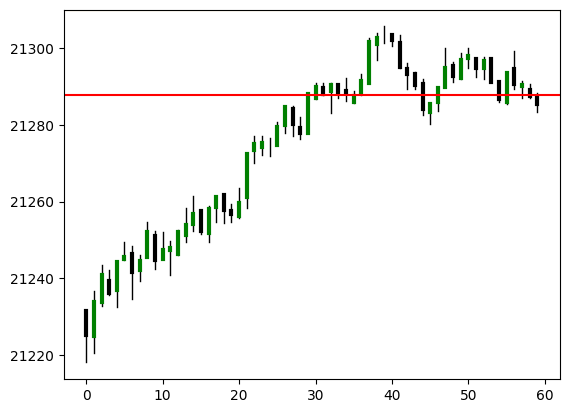

In [6]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1

plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

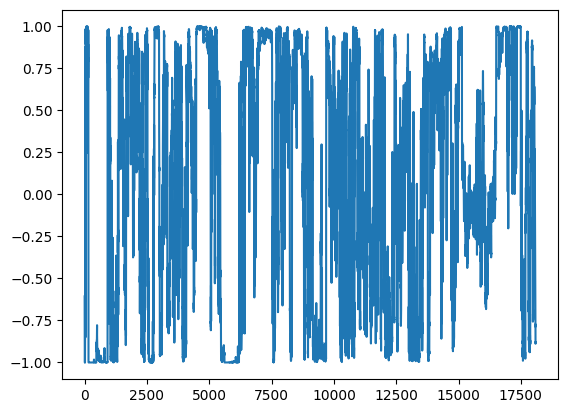

In [7]:
plt.plot(outputs)

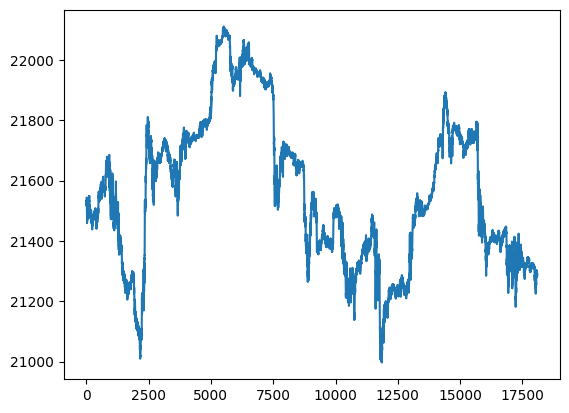

In [8]:
plt.plot([x.c for x in all_candles])

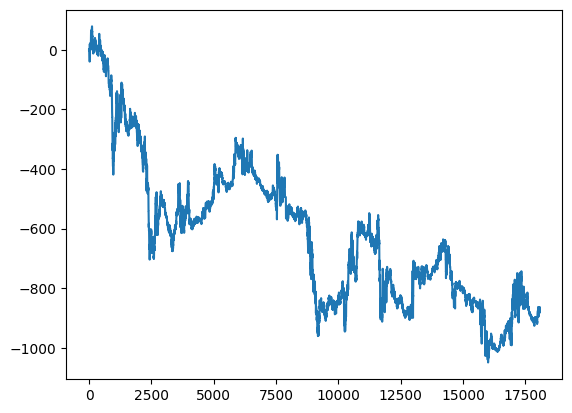

In [9]:
plt.plot(equity_L)